# HITS Algorithm Analysis

In [192]:
import collections
import logging
import time
import json
import copy

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy

import cc_graph_ops
import graph_tool.all as gt
import graph_tool.topology as topo

In [2]:
with open('fdg_input_file.json', 'r') as myfile:
    data = json.load(myfile)

In [3]:
g = cc_graph_ops.create_graph_from_file('fdg_input_file.json')

In [4]:
hubs5, authorities5 = nx.hits(g, max_iter=5, tol=0.5)
# running HITS for 5 iterations takes ~1.5 minutes

In [156]:
# Let's look at what domains have the highest hub scores
# Generally small blogs
print("URL/domain", "\tHub score")
sorted_hubs5 = dict()
for key in hubs5.keys():
    if hubs5[key] > 5e-3 and hubs5[key] != 0:
        sorted_hubs5.update({key: hubs5[key]})
sorted_hubs5 = dict(sorted(sorted_hubs5.items(), key = lambda item: item[1], reverse=True))
# print(len(sorted_hubs5.keys()))
for key in sorted_hubs5.keys():
    template="{:<30}{:>10.17f}"
    print(template.format(key, sorted_hubs5[key]))

URL/domain 	Hub score
blogspot                      0.25785766565817841
scssoft                       0.03164408765434715
lapinturera                   0.01241109884048398
asopaipas                     0.01208000332119373
theartofrandomwillynillyness  0.01109585871289866
marilynsclosetblog            0.00907975449203492
simplysensationalfood         0.00865657920319407
entrebrochasypaletas          0.00834816400385497
shecanquilt                   0.00759912793127838
mamanstestent                 0.00654864710061826
alasdeangel                   0.00647259220012169
hotwhopper                    0.00621623134931996
frugalcreativity              0.00547467337528710
lacreativitadianna            0.00540254273276972


In [154]:
# Let's look at what domains have the highest authority scores
# They seem to be large reference websites
high_authorities_dict = {}
print("URL/domain", "\tAuthority score", "\tHub Score")
for key in authorities5.keys():
    if authorities5[key] > 5e-3 and authorities5[key] != 0:
        high_authorities_dict[key] = authorities5[key]
        print(key, "  \t", authorities5[key], "\t", hubs5[key], sep='')

URL/domain 	Authority score 	Hub Score
blogger  	0.7091617619081793	9.949799584499168e-08
flickr  	0.006697952105011246	3.6129662774951237e-06
wikimedia  	0.007665332925470279	0.00013282349530292014
youtube  	0.006614426118452031	1.731308800464803e-07
google  	0.03136283514217295	2.6721312908112873e-05
stackoverflow  	0.01793854541266114	8.814122714550063e-05
feedburner  	0.011380053402204408	1.0741374911335669e-06
amazon  	0.007312069325881605	6.219078306842094e-08
wikipedia  	0.005771785860349045	0.0019921961132283715
twitter  	0.014965460124294583	2.5145872283305484e-10
wordpress  	0.023459643909888164	0.0018171303945901432
facebook  	0.012501475233602856	0.0


In [159]:
def get_license_qty(g):
    """Takes a graph and returns the license quantity of any node."""
    licenses = []
    for node_id, license_count in g.nodes(data='licenses_qty'):
        licenses.append(int(license_count))
    return np.array(licenses)

def get_cc_license_qty(g):
    """Takes a graph and returns the number of cc licenses of any node."""
    license_count = []
    for node_id, cc_licenses in g.nodes(data='cc_licenses'):
        counter = 0
        if type(cc_licenses)==dict:
            vals = cc_licenses.values()
            for x in vals:
                counter += x
        license_count.append(counter)
    return np.array(license_count)

def filter_all_cc_licenses(g):
    """Takes a graph g and returns a list of nodes that have only CC licenses."""
    
    invalid_node_ids = []
    for node_id, node_metadata in g.nodes(data=True):
        # format: (node_id, {'cc_licenses': n, 'licenses_qty': m, 'other attrs': 'attr_data'}), ...
        counter = 0
        if type(node_metadata['cc_licenses']) == dict:
            for val in node_metadata['cc_licenses'].values():
                counter += val
        if int(counter) != int(node_metadata['licenses_qty']):
            invalid_node_ids.append(node_id)
    g.remove_nodes_from(invalid_node_ids)
    return g

In [160]:
# Make a copy of g to construct a subgraph with nodes that use exclusively CC licenses
g_copy = copy.deepcopy(g)
cc_subgraph = filter_all_cc_licenses(g_copy)

In [161]:
# Run HITS on the reduced graph
start = time.perf_counter()
hubs_cc, authorities_cc = nx.hits(cc_subgraph, tol=0.1)
end = time.perf_counter()
print((end-start)/60, "minutes")

0.38378443999999945 minutes


In [179]:
# Let's look at what domains have the highest hub/authority scores in this reduced graph
print("URL/domain", "\t\tHub score", "\t\tAuthority Score")
template3="{:<24}{:<23.17f}{:>20.17f}"
for key in hubs_cc.keys():
    if hubs_cc[key] > 5e-3 and hubs_cc[key] != 0:
        print(template3.format(key, hubs_cc[key], authorities_cc[key]))
print("\n")

print("Hub scores of high-authority sites:")
for key in high_cc_authorities_dict.keys():
    template="{:<24}{:>10.17f}"
    print(template.format(key, hubs_cc[key]))

URL/domain 		Hub score 		Authority Score
toidicodedao            0.00698701379254315     0.00000027502001664
startups-list           0.00652515712003559     0.00556081629708550
marilynsclosetblog      0.00545838176724295     0.00000000000000000
skidkaonline            0.00550085985526573     0.00000000000000000
brasildefato            0.00695338465179413     0.00089290084941206
laespadaenlatinta       0.00663046055069237     0.00000003075921341
solitariosinvisibles    0.01738148994489122     0.00000000000000000
bulgarian-football      0.00551804690517656     0.00000000716533863
bashkortostan           0.00735433360179777     0.00000069038174975


Hub scores of high-authority sites:
startups-list           0.00652515712003559
avc                     0.00000063559951764
rada                    0.00004111166829409
ok                      0.00001424617180565
flaticon                0.00000515708318046
feedblitz               0.00000015959980068
studentdoctor           0.00056254159742869
t

## Results from the HITS Algorithm

The HITS algorithm is a ranking algorithm which assigns "hub" and "authority" scores to websites. The idea behind the algorithm is that websites that are large websites with authoritative information, as well as hubs, which may not contain much information themselves but link to other websites with authoritative information. 

Upon running the HITS algorithm and looking at the nodes with the largest scores, we see that the nodes with the highest authority scores are large reference websites, like google, StackOverflow, Twitter, and Wikipedia. However, the nodes with the highest hub scores (with the exception of blogspot) were small blogs, usually run by individuals with niche interests. Just by spot-checking the websites, they seemed to have many links and images, many of which probably link to nodes with higher authority scores. We spot-checked the top 14 websites, and we noticed that 5 of them were dead, 1 was a website for a small company that made vehicle-driving simulators, and the others were all blogs.

Out of curiosity, we decided to check the hub scores of the most "authoritative" websites. The only websites that had high hub scores were Wikipedia/Wikimedia and Wordpress. Shockingly, Facebook had a hub score of 0 (due to how Python floating-points work, its hub score is below $10^{-50}$!).

## 100%-CC-licensed websites with high hub/authority scores
The results were extremely different from when we ran HITS on the entire graph. We believe this is because the larger websites have a more diverse set of sources, and thus are likely to use licenses other than CC licenses. Namely, running HITS on the entire graph produced mostly food or lifestyle blogs as the highest hub scoring domains, likely due to the fact that those blogs used a lot of original photos. On the flip side, running HITS on this graph gave almost all relatively-unknown websites.

A lot of the high hub scoring, 100% CC licensed websites were in non-English languages. Out of the top 10 that we spot-checked, 5 were for news sources. There was also 1 shopping site, 2 blogs, and 2 professional development sites. Similarly, news sites may have high hub scores because they're likely to put CC licenses on media that they produce, and link to other reputable sources in their news articles.

We believe that the websites with the highest authority score in the 100% CC-licensed graph are likely to be the experts in their respective domains, which means they might indicate small communities! These are worth investigating further.

# k-cores and degree analysis

In [25]:
start = time.perf_counter()
k_cores = nx.k_core(g)
end = time.perf_counter()
print((end-start)/60, "minutes")

40.08146744999999 minutes


In [11]:
gt_graph = cc_graph_ops.create_graph_from_file('fdg_input_file.json')

In [182]:
test_subgraph = cc_graph_ops.restrict_graph_by_license(gt_graph, "('by-nc', '3.0')")
start = time.perf_counter()
k_cores = nx.k_core(test_subgraph)
end = time.perf_counter()
print((end-start)/60, "minutes")
# nx.draw_kamada_kawai(k_cores)
# turn this into graph-tool graph
test_subgraph_gt = cc_graph_ops.nx2gt(test_subgraph)

0.009394279999984672 minutes


original graph has 3942 vertices and 2606 edges
new graph has 140 vertices and 696 edges


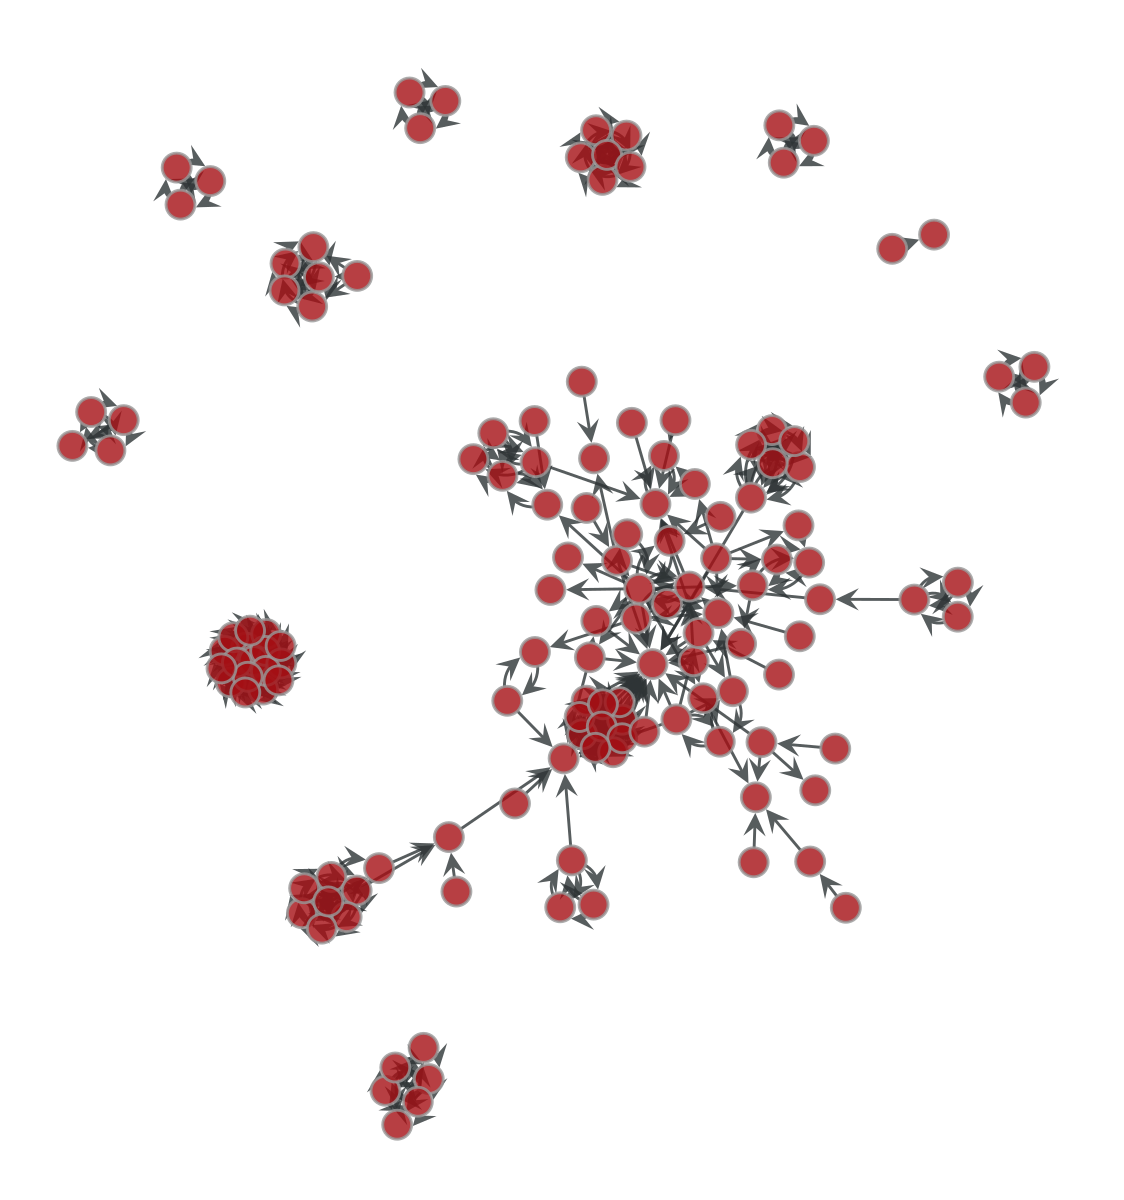

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f80d655ea60, at 0x7f80d4307550>

In [210]:
# graph_tool is faster for nitty-gritty graph manipulations
def d_cores(k, l, gt_digraph):
    """Takes integers k and l and graph-tools directed graph gt_digraph and returns its (k,l) d-cores"""
#     remove all vertices that have indegree < k or outdegree < l
    f = gt_digraph.copy()
    to_remove = []
    for node in f.vertices():
        if f.get_in_degrees([node]) < k or f.get_out_degrees([node]) < l:
            to_remove.append(node)
    f.remove_vertex(to_remove)
#     do 1 more pass to remove isolated vertices
    lone_nodes = []
    for node in f.vertices():
        if f.get_in_degrees([node]) == 0 and f.get_out_degrees([node]) == 0:
            lone_nodes.append(node)
    f.remove_vertex(lone_nodes, fast=True)
    return f
print("original graph has", len(test_subgraph_gt.get_vertices()), "vertices and", len(test_subgraph_gt.get_edges()), "edges")
d = d_cores(2,2, test_subgraph_gt)
print("new graph has", len(d.get_vertices()), "vertices and", len(d.get_edges()), "edges")

gt.graph_draw(d)

(array([42., 28., 10., 25.,  8., 10.,  0.,  0.,  0., 17.]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ]),
 <BarContainer object of 10 artists>)

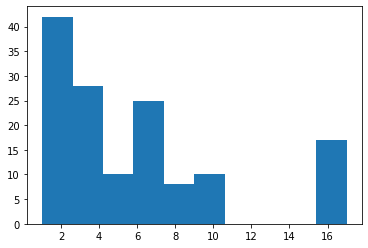

In [222]:
# for node in topo.extract_largest_component(d, directed=False).vertices():
#     print(d.vertex_properties['provider_domain'][node])
# print(len(list(topo.extract_largest_component(d, directed=False).vertices())))
comp, hist = topo.label_components(d)
plt.hist([hist[i] for i in comp])
# make a set of component labels, and grab the nodes with the same component label
# the above code currently doesn't work -- the array of vertices is strangely... empty?

In [133]:
def summary_np_array(graph):
    max_indegree = max(list(graph.get_in_degrees(list(graph.vertices()))))
    max_outdegree = max(list(graph.get_out_degrees(list(graph.vertices()))))
    edge_dist = np.empty(shape=(max_indegree, max_outdegree), dtype='int32')
    vertex_dist = np.empty(shape=(max_indegree, max_outdegree), dtype='int32')
    for i in range(max_indegree):
        for j in range(max_outdegree):
            d = d_cores(i, j, graph)
#             print("graph has", len(d.get_vertices()), "vertices and", len(d.get_edges()), "edges")
            vertex_dist[i][j] = len(d.get_vertices())
            edge_dist[i][j] = len(d.get_edges())
    return vertex_dist, edge_dist

start = time.time()
print(summary_np_array(test_subgraph_gt)[1])
end = time.time()
print(end - start, "seconds")
# print(summary_np_array(test_subgraph_gt)[1])

[[467 182 121  62  38  26  26  11   7   7]
 [204 149 106  53  38  26  26  11   7   7]
 [112 101  94  49  35  26  26  11   7   7]
 [ 67  62  57  35  22  15  15   5   5   5]
 [ 37  33  32  17  11   6   6   2   2   2]
 [ 18  14  14  11  11   6   6   2   2   2]
 [ 14  14  14  11  11   6   6   2   2   2]
 [ 14  14  14  11  11   6   6   2   2   2]
 [ 14  14  14  11  11   6   6   2   2   2]
 [ 11  11  11  11  11   6   6   2   2   2]
 [  1   1   1   1   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  

In [71]:
node_indegrees = np.empty(1)
node_outdegrees = np.empty(1)
start = time.perf_counter()
for node in g.nodes:
    node_indegrees = np.append(node_indegrees, g.in_degree(node))
    node_outdegrees = np.append(node_indegrees, g.out_degree(node))
    
end = time.perf_counter()
print(end - start, "seconds")

174.20044189999862 seconds


(array([1.7631e+04, 0.0000e+00, 2.1242e+04, 2.2360e+04, 2.1556e+04,
        3.2810e+04, 2.0671e+04, 1.8785e+04, 1.4219e+04, 1.0677e+04,
        8.7630e+03, 7.2850e+03, 5.6710e+03, 4.1050e+03, 2.9990e+03,
        2.2320e+03, 1.5680e+03, 1.1130e+03, 7.7800e+02, 4.6700e+02,
        2.8600e+02, 1.8400e+02, 1.0100e+02, 6.1000e+01, 2.0000e+01,
        2.0000e+01, 2.0000e+01, 1.0000e+01, 6.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0.        ,  0.30272883,  0.60545766,  0.90818649,  1.21091533,
         1.51364416,  1.81637299,  2.11910182,  2.42183065,  2.72455948,
         3.02728831,  3.33001715,  3.63274598,  3.93547481,  4.23820364,
         4.54093247,  4.8436613 ,  5.14639013,  5.44911897,  5.7518478 ,
         6.05457663,  6.35730546,  6.66003429,  6.96276312,  7.26549195,
         7.56822079,  7.87094962,  8.17367845,  8.47640728,  8.77913611,
         9.08186494,  9.38459377,  9.68732261,  9.99005144, 10.29278027,
        10.

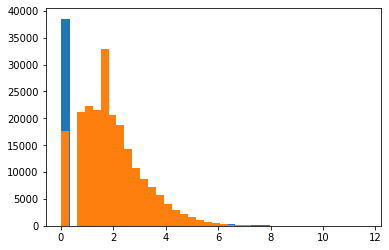

In [66]:
# Indegree distribution
plt.hist([np.log(i) for i in node_indegrees if i != 0], bins=35)
# Outdegree distribution
plt.hist([np.log(i) for i in node_outdegrees if i != 0],bins=35)

Notice that the indegree distribution is exponential, while the outdegree distribution does not peak at 0. It looks like a Poisson or gamma distribution, and is most likely a gamma distribution, which is the sum of exponentials.